In [1]:
import os
import torch
import torchaudio
from matplotlib import pyplot as plt
from IPython.display import Audio, display, clear_output
import math
import numpy as np
import pandas as pd
import pickle
import time
import shutil
from cepstrum import cepstrum

In [15]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [46]:
class Station:
    
    def __init__(self, name, thrshold):
        self.name = name
        self.thrshold = thrshold
        self.events = []
        
    def set_event(self, event):
        if (event.duration >= self.thrshold):
            self.events.append(event)

class Event:
    
    def __init__(self, name, wav_dir, station):
        self.name = name
        self.station = station
        self.kind = ''
        self.duration = 0.0
        self.power = 0.0
        self.calculator(name, wav_dir)
    
    def calculator(self, audio, wav_dir):
        self.kind_set(audio)
        self.audio_average_power(wav_dir)
    
    def audio_average_power(self, wav_dir):
         
#         main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
        main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"

        wav_path = os.path.join(main + wav_dir, self.name)
        waveform, sample_rate = torchaudio.load(wav_path)
        num_channels, num_frames = waveform.shape
        
        if waveform.numpy().shape[1] != 0:
            
            ft_wf = np.fft.fft(waveform.numpy())/(math.sqrt(waveform.numpy().shape[1]))
            
            parseval_waveform = np.sum(waveform.numpy()**2)
            parseval_fourier_transform = np.sum(np.abs(ft_wf)**2)
            
            if (np.float32(round(parseval_waveform,1)) == np.float32(round(parseval_fourier_transform,1))):
                
                self.power = parseval_waveform
                
                duration = torch.arange(0, num_frames) / sample_rate
                self.duration = duration.numpy()[-1]
            
    def kind_set(self, audio):
        text = audio.split('_')
        self.kind = text[2]

def folders(wav_dir, station):
    
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    wav_noise_names = os.listdir(wav_dir + noise)
    wav_not_noise_names = os.listdir(wav_dir + not_noise)
    
    print(station.name, " -> In Noise folder")
    
    for w in wav_noise_names:
        station.set_event(Event(w, wav_dir + noise, station.name))
    
    print(station.name, " -> In Not Noise folder")
    
    for nn in wav_not_noise_names:
        station.set_event(Event(nn, wav_dir + not_noise, station.name))
    
    return station

def dataframer(stations):
    
    thrshold = 0.5
    data = []
    framer = []
    
    for s in stations:
        
        data.clear()
        
        for e in s.events:
            
            if e.duration >= thrshold:
                data.append([s.name, e.name, e.kind, e.duration, e.power])
        
        framer.append(pd.DataFrame(data.copy(), columns = ['station', 'audio', 'class', 'duration', 'power']))
    
    return framer

#returns a slice of dataframes!!
def _initiator(thrshold):
    
    stations = []
    fls = []

#     main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
#     wav_dir = '/home/kasparov/Documentos/20190114_vpoblete/20221019_Wasserstein/'
    
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda1/")
    fls.append("split_signals_into_labels_and_noise_20221022_for_ronda2/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda3/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda4/")
    fls.append("split_signals_into_labels_and_noise_20221020_for_ronda5/")
    fls.append("split_signals_into_labels_and_noise_20221022_for_ronda6/")
    
    
    for f in fls:
        stations.append(Station(f.split("_")[8], thrshold))
    
    for s in stations:
        
        for f in fls:
            if(f.split("_")[8] == s.name):
                print("Working in: ", s.name)
                s = folders(f, s)
                break
            
    return stations, fls

def _writer(stations):
    
    filewriter = open("stations/stations.fusa", "wb")
    stations = pickle.dump(stations, filewriter)
    filewriter.close()
    
def _reader():
    
    filereader = open("stations/stations.fusa", "rb")
    stations = pickle.load(filereader)
    filereader.close()
    
    return stations

def _copier(stations, fls):
    
#     main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
    main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    
    for s in stations:
        counter = 0
        l = len(s.events)
        
        for e in s.events:
            
            clear_output()
            print("In ", s.name, "  Files copied:  ",counter, "/", l)
            for f in fls:
                if(e.station == f.split("_")[8]):
                    counter = counter + 1

                    if("ruido" in e.name):
                        item = main+f+noise+e.name
                        shutil.copy(item, main+"stations/"+noise)
                        break
                    else:
                        item = main+f+not_noise+e.name
                        shutil.copy(item, main+"stations/"+not_noise)
                        break
                        
def _npz_copier(stations, fls):
    
#     main = '/home/kasparov/Documentos/20190114_vpoblete/20221027_joaquin/fusa_power/'
    main = "Z:/Proyectos/AuMiLab/FUSA/Noise/fusa_power/"
    
    noise = 'ruido/'
    not_noise = 'audios_all_classes/'
    
    for s in stations:
        counter = 0
        l = len(s.events)
        
        for e in s.events:
            
            clear_output()
            print("In ", s.name, "  Files copied:  ",counter, "/", l)
            for f in fls:
                if(e.station == f.split("_")[8]):
                    
                    if("ruido" in e.name):
                        item = main+f+noise
                        filename = item+e.name
                        newit = main + "stations/" + noise
                        
                        cep_filename = cepstrum(filename)
                        newfile = newit+e.station.replace('/', '')+'_'+'noise'+str(counter)+'.npz'
                        np.savez(newfile, cep_filename)
                        counter += 1
                        break
                        
                    else:
                        item = main+f+not_noise
                        filename = item+e.name
                        newit = main + "stations/" + not_noise
                        
                        cep_filename = cepstrum(filename)
                        newfile = newit+e.station.replace('/', '')+'_'+'event'+str(counter)+'.npz'
                        np.savez(newfile, cep_filename)
                        counter += 1
                        break
            
                        
    

In [7]:
start = time.time()

stations, fls = _initiator(0.5)

end = time.time()

print(round(end-start,1))

_writer(stations)

Working in:  ronda1/
ronda1/  -> In Noise folder
ronda1/  -> In Not Noise folder
Working in:  ronda2/
ronda2/  -> In Noise folder
ronda2/  -> In Not Noise folder
Working in:  ronda3/
ronda3/  -> In Noise folder
ronda3/  -> In Not Noise folder
Working in:  ronda4/
ronda4/  -> In Noise folder
ronda4/  -> In Not Noise folder
Working in:  ronda5/
ronda5/  -> In Noise folder
ronda5/  -> In Not Noise folder
Working in:  ronda6/
ronda6/  -> In Noise folder
ronda6/  -> In Not Noise folder
10.7


In [8]:
stations = _reader()

In [9]:
fls=[]
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda1/")
fls.append("split_signals_into_labels_and_noise_20221022_for_ronda2/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda3/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda4/")
fls.append("split_signals_into_labels_and_noise_20221020_for_ronda5/")
fls.append("split_signals_into_labels_and_noise_20221022_for_ronda6/")

In [10]:
stations

In [47]:
_npz_copier(stations, fls)

In  ronda6/   Files copied:   1 / 2


In [32]:
df = dataframer(stations)

<AxesSubplot: xlabel='duration', ylabel='power'>

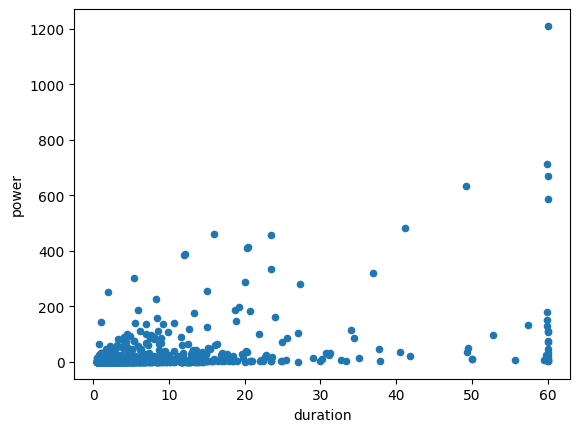

In [33]:
df[0].plot(x='duration', y='power', kind='scatter')	